[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

# Setting up the environment

In [9]:
!pip install transformers

In [10]:
from google.colab import drive

current_directory = '/content/drive/My Drive/FSem/'
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Headers and Base Model

In [11]:
import torch
from transformers import BertForNextSentencePrediction, BertTokenizer
import matplotlib
from matplotlib import pyplot as plt

base_model = BertForNextSentencePrediction.from_pretrained('bert-large-uncased-whole-word-masking')

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Weight Difference Function

In [12]:
def weight_diff(model1, model2):
    model1, model2 = model1.to("cpu"), model2.to("cpu")
    diff = torch.nn.MSELoss() # diff(a, b) = ((a - b) ** 2).mean()

    xweights, yweights, xbiases, ybiases = dict(), dict(), dict(), dict()
    layer_names = list()

    for (name, parameter1), parameter2 in zip(
        model1.bert.encoder.layer.named_parameters(),
        model2.bert.encoder.layer.parameters()
    ):

        difference = diff(parameter1, parameter2).item()

        name = name.split(".")
        xtick = float(name[0])
        layer_name = ".".join(name[1:-1])
        parameter_type = name[-1]

        if layer_name not in layer_names:
            layer_names.append(layer_name)
            xweights[layer_name], xbiases[layer_name] = list(), list()
            yweights[layer_name], ybiases[layer_name] = list(), list()

        if parameter_type == "weight":
            yweights[layer_name].append(difference)
            xweights[layer_name].append(xtick + 0.0)
        else: # if parameter_type == "bias"
            ybiases[layer_name].append(difference)
            xbiases[layer_name].append(xtick + 0.5)

    for name in layer_names:
        plt.bar(xweights[name], yweights[name], width=0.4, label="weight")
        plt.bar(xbiases[name], ybiases[name], width=0.4, label="bias")
        plt.xticks(xweights[name])
        plt.legend()
        plt.title(name)
        plt.show()

# Cloze Only

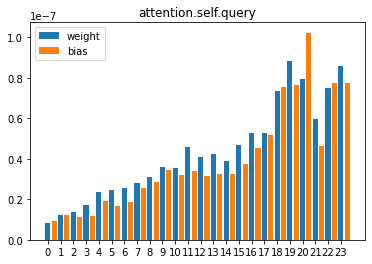

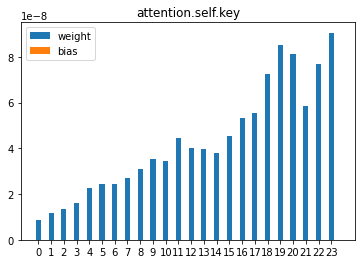

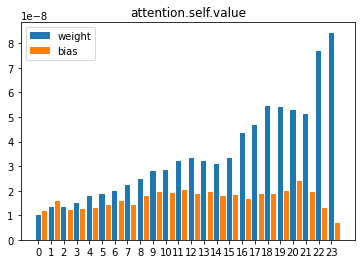

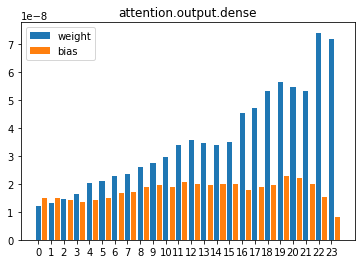

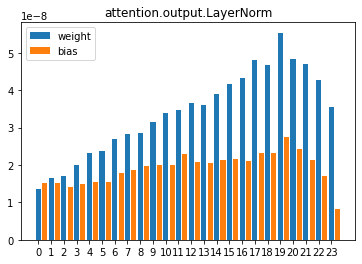

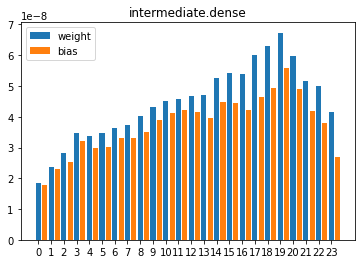

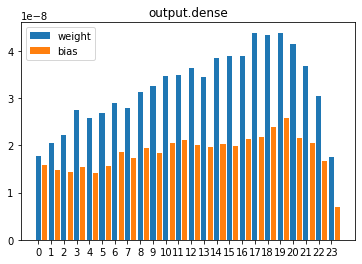

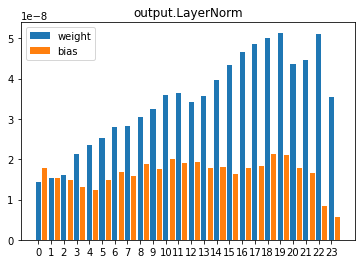

In [13]:
model = BertForNextSentencePrediction.from_pretrained(current_directory + 'shared/bertfornsp_clozeonly_finetuned10')
weight_diff(base_model, model)

# Roc Only

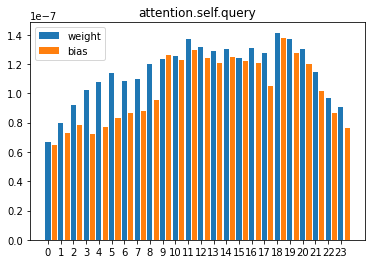

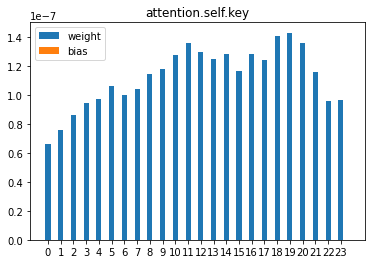

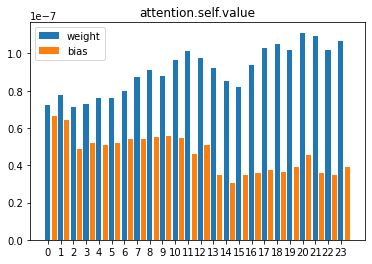

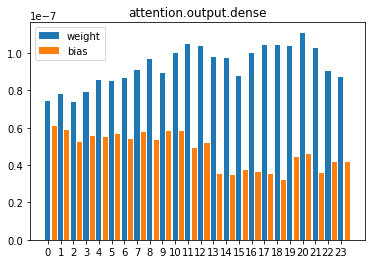

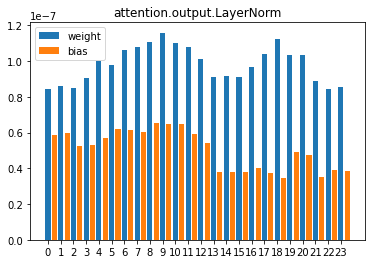

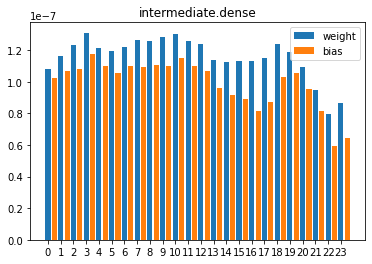

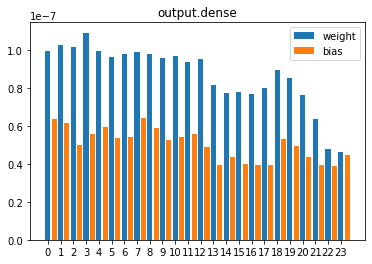

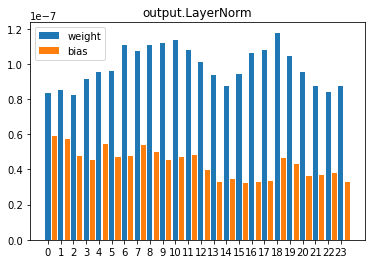

In [14]:
model = BertForNextSentencePrediction.from_pretrained(current_directory + 'shared/bertfornsp_roc_finetuned1')
weight_diff(base_model, model)

# Mixed

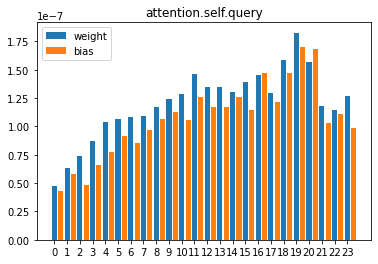

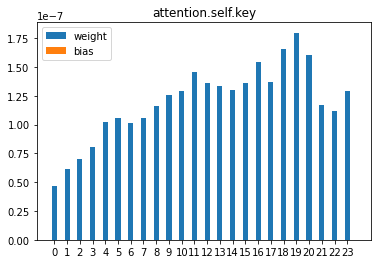

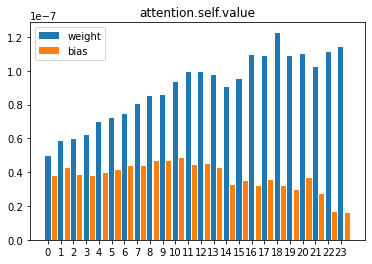

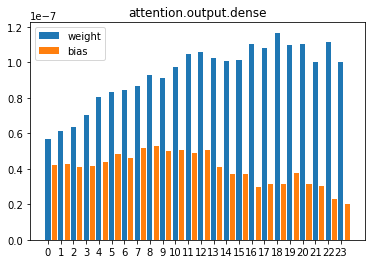

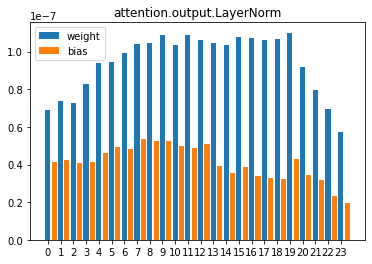

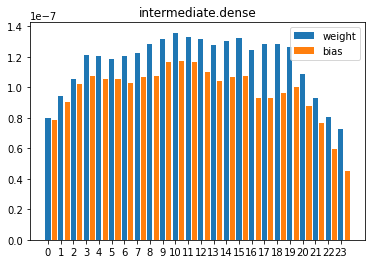

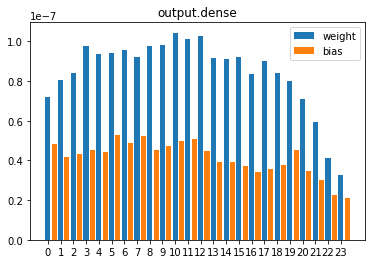

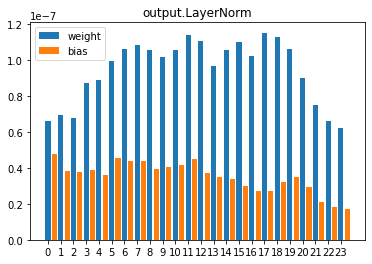

In [15]:
model = BertForNextSentencePrediction.from_pretrained(current_directory + 'shared/bertfornsp_mixed5')
weight_diff(base_model, model)